<img src="https://www.strath.ac.uk/media/1newwebsite/webteam/logos/xUoS_Logo_Horizontal.png.pagespeed.ic.M6gv_BmDx1.png" width="350" align="left" style="left">

# OFDM Fundamentals

This notebook introduces the fundamental theory of Orthogonal Frequency Division Multiplexing (OFDM). OFDM is a form of digital multi-carrier modulation that has been adopted as the basis of several modern wireless standards such as Wi-Fi, 4G and now 5G.  

## Aims 

* Provide an overview of the OFDM transmission process
* Discuss the role of the IFFT & FFT in OFDM  
* Provide a brief summary of multipath channels
* Demonstrate the purpose of the Cyclic Prefix 

##  Table of Contents 

* [1. Introduction](#introduction)
* [2. OFDM Transmitter](#ofdmtx)
   * [2.1 Baseband Symbol Generation](#baseband)
   * [2.2 Serial to Parallel Converter](#s2p)
   * [2.3 Sub-carrier Modulation](#scmod)
   * [2.4 Sub-carrier addition](#scadd)
   * [2.5 Modulation using the IFFT](#IFFT)
* [3. The Multipath Channel](#multipath)
   * [3.1 Effect of Multipath Channel on OFDM Signals](#mpofdm)
* [4. The Cyclic Prefix](#cp)
  * [4.1 One Tap Equaliser](#onetap)
* [5.Updated OFDM Transmitter](#tx_update)
* [6.Conclusion](#conclusion)

## 1. Introduction <a class="anchor" id="introduction"></a>

In this notebook, the fundamentals of OFDM are introduced. OFDM is a digital multi-carrier modulation method used in several wireless communications standards, such as the IEEE 802.11 family (Wi-Fi), 4G Long Term Evolution (LTE) and most recently 5G New Radio (NR). 

In OFDM, a high rate symbol stream (QPSK, QAM etc.) is transmitted as a sum of several parallel low rate streams, that each modulate a different orthogonal sub-carrier. OFDM allows for a computationally efficient channel equalisation process and provides the ability to completely eliminate Inter Symbol Interference (ISI). Also, the use of orthogonal sub-carriers produces a very spectrally efficient transmission.  

The orthogonal modulation and demodulation processes are equivalent to the Inverse Discrete Fourier Transform (IDFT) and DFT respectively, allowing OFDM to be implemented efficiently using Fast Fourier Transform (FFT) algorithms. The use of independent sub-carriers also leads to a convenient multiple access scheme, where the available sub-carriers are shared among several different users. This is known as Orthogonal Frequency Division Multiple Access (OFDMA). 

## 2. OFDM Transmitter <a class="anchor" id="ofdmtx"></a>

In this section, we will go through each step of the OFDM modulation process. A high level overview of an OFDM transmitter is shown below:

<a class="anchor" id="fig-2.1"></a>
<figure>
<img src="images/ofdm_tx_1 copy.svg" style="width: 900px;"/> 
    <figcaption><b>Figure 2.1: OFDM Transmitter</b></figcaption>
</figure>     

Firstly, we have to import the necessary libraries and helper functions:

In [33]:
# Import necessary libraries 
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal

# Import helper function
from helper_functions import symbol_gen, awgn, psd, \
frequency_plot, scatterplot, calculate_evm

To begin with, let us define the modulation scheme (BPSK, QPSK or 16-QAM) and symbol rate of the initial high rate symbol stream:

In [34]:
mod_scheme = 'QPSK' # Modulation scheme 
fs = 20e6 # Initial symbol rate

In OFDM systems, the baseband modulation scheme is a form of Quadrature Amplitude Modulation (QAM). It can vary from BPSK at the lowest to 1024-QAM or higher in the latest standards. Using higher levels of QAM allows a larger amount of data to be transmitted within a fixed bandwidth. The rate of the initial symbol stream is denoted by,$f_{s}$, since it is equivalent to the sampling rate in OFDM systems. Let's now define the number of sub-carriers, $N$: 

In [35]:
N = 64 # No. of sub-carriers 

As indicated by the diagram, the high rate data stream is divided into $N$ parallel low rate streams using a serial to parallel converter. As a result, the symbol rate, $R$, of each parallel stream is:  

In [36]:
R = fs/N # symbol rate of parallel data streams

and the symbol period $T$ is: 

In [37]:
T = 1/R # symbol period of parallel data streams

Each lower rate stream modulates a different one of the $N$ sub-carriers. The value $N$ is chosen to ensure that the channel frequency repsonse is effectively constant across the sub-carrier bandwidth (equivalent to $R$). This facilitates simplified frequency domain equalisation of each sub-carrier in the receiver. The process of equalising several parallel sub-carriers in the frequency domain is much more computationally efficient than the time domain equalisation traditionally used in single carrier systems. Having independent sub-carriers also leads to OFDMA, which is an efficient multiple access scheme where groups of sub-carriers are assigned to different users. OFDMA is employed in 4G LTE, 5G NR and some of the later Wi-Fi standards.  

The sub-carrier spacing (in frequency) is also set equal to $R$:

In [38]:
deltaf = R # Sub-carrier spacing 

$\Delta f$ is set to the minimum spacing required to achieve orthogonality between sub-carriers. We'll just accept this as fact for now, but will provide justification in a later section. Orthogonality is useful because it allows tight overlap of sub-carriers in frequency, mitigating the need for guard bands to keep the sub-carriers separated. This leads to a much more efficient use of bandwidth than can be achieved with generic Multi-Carrier Modulation (MCM). Moreover, it removes the need for expensive bandpass filters to recover the sub-carriers in the receiver. 

Also, notice the number of sub-carriers has been set to a power of 2. This is because later we'll show that OFDM is implemented using FFT algorithms, which use power of 2 lengths.

As indicated in [Figure 2.1](#fig-2.1), the different lower rate streams modulating each sub-carrier  are summed together to produce the OFDM signal. Since the symbol period on each sub-carrier is $T$, it follows that the OFDM symbol period is also $T$ and the OFDM symbol rate is $f_{s}/N$. 

### 2.1 Baseband Symbol Generation <a class="anchor" id="baseband"></a>

With reference to [Figure 2.1](#fig-2.1), we will now go through each step in generating an OFDM signal. The first step is generating the data symbols i.e. BPSK, QPSK and 16-QAM in this case. In real life, we begin with data bits and map these to symbols (BPSK, QPSK etc.), but we will skip this stage here. More information about this can be found in the notebook on Baseband Modulation. 

In [39]:
n_ofdm = 500 # No. of OFDM symbols
nsym = n_ofdm * N # No. of data symbols 

# Generate data symbols
data_serial = symbol_gen(nsym,mod_scheme)

Notice we have set the number of OFDM symbols, $N_{ofdm}$, that we want to generate. Since each OFDM symbol is comprised of a sum of $N$ parallel data symbols each modulating a different sub-carrier, it follows that we need to generate $NN_{ofdm}$ data symbols. The baseband constellation is plotted below:

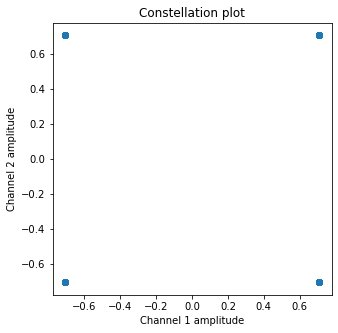

In [40]:
# Plot constellation 
scatterplot(data_serial.real,data_serial.imag,ax=None)

### 2.2 Serial to Parallel Converter <a class="anchor" id="s2p"></a>

We can now convert the high rate stream to $N$ parallel low rate streams: 

In [41]:
# Matrix to hold parallel low rate data streams
data_parallel = np.zeros((N,n_ofdm),np.complex64)  
j= 0

# Serial to Parallel converter
for i in range(n_ofdm):
    data_parallel[:,i] = data_serial[j:j+N]
    j = j + N

### 2.3 Sub-carrier Modulation <a class="anchor" id="scmod"></a>

The parallel low rate streams then modulate each of the sub-carriers. In this example, all sub-carriers are being used to transmit data symbols. However, in real systems, pilot sub-carriers are embedded in the OFDM symbol for synchronisation and channel estimation tasks in the receiver. Also, the outer sub-carriers (i.e. those closest to the edges of the transmit frequency band) are often left blank to mitigate the need for expensive anti-imaging and and anti-alisaing filters in the transmitter and receiver respectively. These are known as null sub-carriers. 

The construction of a single OFDM symbol can be expressed mathematically as: 

$$x[n]=\sum_{k=0}^{N-1} X[k]e^{j2 \pi k (\Delta f / f_{s}) n},$$

where $x[n]$ is the OFDM symbol, $X[k]$ is the $k^{th}$ input symbol, $\Delta f$ is the sub-carrier spacing, $\textit{n}$ is the sample index and $\textit{k}$ is the sub-carrier index. Recall that the OFDM symbol period is $T$, which equals $N/f_{s}$. Therefore, there are $N$ samples per OFDM symbol. 

At this stage, we'll generate the $N$ orthogonal sub-carriers:

In [42]:
sc = np.zeros((N,N),np.complex64) # Matrix to hold sub-carriers 
k = np.arange(N) # Define sub-carrier indices i.e. [0,1....N-1]
n = k # Discrete time index  

# Generate sub-carriers  
for i in range(N):
    sc[i,:] = np.exp(1j*2*math.pi*k[i]*(deltaf/fs)*n)

As you might expect, there are $N$ sub-carriers and $N$ samples per sub-carrier. Note we are only generating $N$ samples of each sub-carrier here, since they are indentical for all subsequent periods of $N$. Let's now modulate the sub-carriers with the parallel data streams:  

In [43]:
# Modulate sub-carriers with data symbols   
sc_mod = np.zeros((N,n_ofdm*N),np.complex64)
j = 0

for i in range(n_ofdm):
    sc_mod[:,j:j+N] = sc * data_parallel[:,i][:, np.newaxis]
    j = j + N

Having modulated the sub-carriers, we will now stop and inspect the frequency spectra of the different sub-carriers. This will be useful in understanding the choice of sub-carrier spacing made earlier in the notebook. Before that though, we need to review some theory in order to understand what to expect. 

As you'll have noticed, no explicit pulse shaping is performed on each of the parallel data streams (e.g. Root Raised Cosine). Therefore, the pulse shaping is implicitly rectangular with a duration $T$.    

From fundamental signal processing theory, we know that a rectangular pulse of duration $T$ has a sinc frequency spectrum, whose zero crossings occur at $\pm{1/T}$ $\textit{Hz}$, $\pm{2/T}$ $\textit{Hz}$,$\pm{3/T}$ $\textit{Hz}$ and so on... Therefore, if we choose a minumum sub-carrier spacing of $1/T$ $\textit{Hz}$, the centre frequency or maximum effect point of each sub-carrier will correspond to the zero crossings of all other sub-carriers. As a result, the sub-carriers are orthogonal. The sub-carrier spacing is given by:

$$ \Delta f = \frac{1}{T}. $$

Substituting the previous equation for $\textit{T}$ gives:

$$ \Delta f = \frac{1}{N / f_{s}} = \frac{f_{s}}{N}. $$

Therefore, this is why we chose a sub-carrier spacing of $\Delta f = f_{s}/N$ earlier in the notebook. It is the smallest spacing that guarantees orthogonality between the sub-carriers. 

In the following code cell, we extract two sub-carriers and plot their Power Specral Densities (PSDs):

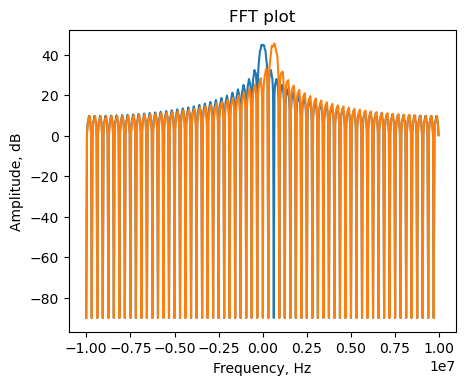

In [44]:
# Extract two sub-carriers and plot together 
sc_1 = sc_mod[0,:] 
sc_2 = sc_mod[2,:]

# Estimate PSDs of sub-carriers 
fft_s = 512
wtype = 'Rectangle' 
overlap = 0
psd_est_1 = psd(sc_1,fft_s,wtype,overlap)
psd_est_2 = psd(sc_2,fft_s,wtype,overlap)

# Convert to dB
epsilon = 1e-9; # Add to avoid divide by zero errors
psd_db_1 = 10 * np.log10(psd_est_1+epsilon) 
psd_db_2 = 10 * np.log10(psd_est_2+epsilon)

# Frequency axis 
freqs = np.linspace(-fs/2,(fs/2 - (fs/fft_s)), fft_s) 

# Plot PSDs
fig=plt.figure(figsize=(5,4), dpi=100)
frequency_plot(freqs, np.fft.fftshift(psd_db_1), ax=None)
frequency_plot(freqs, np.fft.fftshift(psd_db_2), ax=None)

As expected, it can be observed that the sub-carriers have a sinc frequency spectrum. Also, due to the choice of spacing, the centre of each sub-carrier correpsonds to the zero crossing of the other sub-carrier. 

It can also be observed that there is interference between the sub-carriers at other frequencies. However, in the receiver, we sample the sub-carrier at its maximum effect point, where the interference from the other sub-carriers is zero. This means that the interference at other frequencies is irrelevant. 

To summarise, the orthogonality property enables the data to be recovered perfectly depsite the fact that the sub-carriers are interfering with one another (just not at the maximum effect points). This mitigates the need for guard bands to keep the sub-carriers separated and expensive bandpass filters to recover each sub-carrier at the receiver. This makes OFDM a very efficient form of MCM.  

In practice, channel and hardware indcued impairments will cause the sub-carrier maximum effect points to drift from the ideal frequencies, leading to Inter Carrier Interference (ICI). This manifests as a form of additive noise that cannot be removed. As a result, we must ensure that ICI is minimised as much as possible.   

### 2.4 Sub-carrier Addition <a class="anchor" id="scadd"></a>

Finally, the sub-carriers are summed to create the OFDM symbol: 

In [45]:
ofdm_data = np.sum(sc_mod,0,np.complex64)/N

### 2.5 Modulation using the IFFT <a class="anchor" id="IFFT"></a>

In practice, the orthogonal modulation process shown above requires $\textit{N}$ complex oscillators at both transmitter and receiver. This makes this form of MCM prohibitivley costly as $\textit{N}$ gets larger. However, this cost can be reduced signiciantly if we realise that the modulation and demodulation processes are equivalent to an IDFT and DFT respectively. As such, we can implement OFDM using FFT algorithms, which are much more computationally efficient. 

As it turns out, it is quite easy to prove that the OFDM modulation process is equivalent to an IDFT. Recall, that the sub-carrier spacing for OFDM, $\Delta_{f}$, is given by: 

$$\Delta_{f} = \frac{f_{s}}{N}.$$

Therefore, if we substitute this equation into our subcarrier modulation equation, it reduces to:

$$x[n]=\sum_{k=0}^{N-1} X[k]e^{j2 \pi k n / N},$$

which is the equation for the IDFT minus the $1/N$ scaling factor. 

We can now compare the OFDM symbols generated using the orthogonal modulation process with the symbols generated by the IFFT to show that they are equivalent:  

In [46]:
# Define function to modulate using IFFT 
def ifft_mod(symbols,N):
    ofdm_data = np.fft.ifft(symbols,N)
    return ofdm_data

#  Generate OFDM symbols using IFFT modulation   
ofdm_data_ifft = np.zeros(n_ofdm*N,np.complex64)
j = 0

for i in range(n_ofdm):    
    ofdm_data_ifft[j:j+N] = ifft_mod(data_serial[j:j+N],N)
    j = j + N  

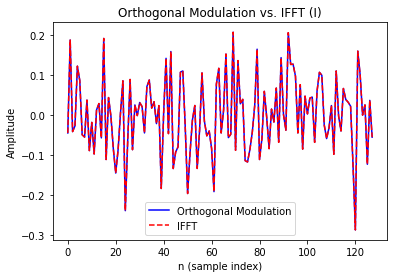

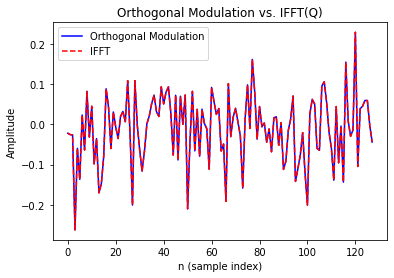

In [47]:
# Compare OFDM symbols generated using orthogonal modulation and IFFT respectively
plt.plot(ofdm_data[0:(2*N)].real,'b')
plt.plot(ofdm_data_ifft[0:(2*N)].real,'--r')
plt.title('Orthogonal Modulation vs. IFFT (I)')
plt.xlabel('n (sample index)')
plt.ylabel('Amplitude')
plt.legend(('Orthogonal Modulation','IFFT'))

plt.figure(2)

plt.plot(ofdm_data[0:(2*N)].imag,'b')
plt.plot(ofdm_data_ifft[0:(2*N)].imag,'--r')
plt.title('Orthogonal Modulation vs. IFFT(Q)')
plt.xlabel('n (sample index)')
plt.ylabel('Amplitude')
plt.legend(('Orthogonal Modulation','IFFT'))

The plots show that the data produced using orthogonal modulation is equivalent to the IFFT. We can also confirm this by measuring the Mean Square Error (MSE) between the data streams:   

In [48]:
mse = np.mean(abs(ofdm_data-ofdm_data_ifft)**2)
mse

3.1304157e-16

Since the IFFT is used for modulation, it follows that the FFT is used for demodulation. 

## 3. The Multipath Channel <a class="anchor" id="multipath"></a>

In a typical wireless channel, the transmitted signal is reflected off objects (buildings, vehicles, foliage etc) in the signal path, leading to several delayed and attenuated copies of the signal arriving at the receiver. The constructive and destructive interference of the multipath components lead to fading of the received signal. The fading effect is frequency selective i.e. different frequencies experience different amounts of fading. 

The channel is characterised by its delay spread, $d_{s}$, which is the difference in time between the first and last multipath arrivals. In the frequency domain, the channel is characterised by its coherence bandwidth, $B_{c}$, which is the range of frequencies over which the fading effect is approximately constant. The two quantities are approximately inversely proportional: 

$$d_{s} \approx \frac{1}{B_{c}}.$$

Depending on the characteristics of the transmitted signal, the channel can be classified as a flat fading or frequency selective fading channel. 

The channel is flat fading when the symbol period is long compared to the channel delay spread, 

$$ T_{sym} \gg d_{s}, $$

where $T_{sym}$ represents the symbol period. In the frequency domain, the signal bandwidth is small compared to the coherence bandwidth, 

$$ B \ll B_{c},$$

where $B$ is the signal bandwidth. A flat fading channel is relatively simple to equalise or compenstate for and there is limited ISI.

Conversely, the channel is experienced as frequency selective if the symbol period is small compared to delay spread, 

$$ T_{sym} \ll d_{s}, $$

and the signal bandwidth is large compared to the coherence bandwidth, 

$$ B \gg B_{c}. $$

The ISI is more severe in a frequency selective channel and it is more challenging to equalise. 

### 3.1 Effect of Multipath channels on OFDM signals <a class="anchor" id="mpofdm"></a>

In OFDM, we choose the number of sub-carriers such that their bandwidth much smaller than $B_{c}$ or equivalently that $T$ is much greater than $d_{s}$. As such, each sub-carrier experiences a flat fading channel. This leads us towards the "one tap" equaliser, which reduces the equalisation process to a single complex scaling per sub-carrier. The one tap equaliser is a major advanatage of OFDM. In addition, the use of orthogonal sub-carriers increases the spectral efficiency of the transmission. 

However, in practice, the multipath channel violates sub-carrier orthogonality and introduces ISI, meaning these advantages are lost. 

A multipath channel can be modelled as a Finite Impulse Response (FIR) filter, since the output signal is equivalent to the convolution of the input signal with the channel impulse response. Each filter coefficient represents a single resolvable multipath component and the length of the filter is dictated by $d_{s}$ i.e. the time difference between the first and last multipath arrivals. 

Let us consider a simple three tap channel filter, as illustrated below:

<a class="anchor" id="fig-3.1"></a>
<figure>
<img src="images/filter copy.svg" style="width: 550px;"/> 
    <figcaption><b>Figure 3.1: Multipath Channel Filter</b></figcaption>
</figure>     

Note this is not an accurate representation of a real channel, but is sufficient for understanding the effects of multipath on OFDM signals. In proper baseband channel models, we use complex weights drawn from a normal distribution. There is also different amounts of delay between the different weights.    

Recall that the OFDM symbol is simply composed of a sum of amplitude and phase modulated complex sinusoids or sub-carriers (formed using IFFT). In order to illustrate the effects of multipath on OFDM, we will consider only a single sub-carrier. The effects described will apply equally to all other sub-carriers. Let us concentrate on the sub-carrier at $k = 1$ as below:

In [49]:
# Sub-carrier at k = 1 or fs/N Hz
n = np.arange(64)
k = 1
sc = np.exp(1j*2*math.pi*k*n/N) 

Now let's extract the real or in-phase component of the sub-carrier and plot it:

Text(0, 0.5, 'Amplitude')

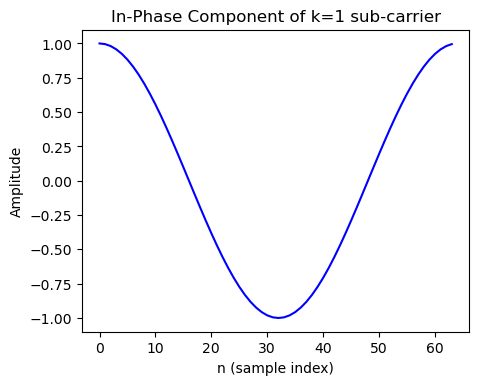

In [50]:
# Extract In-Phase component
sc_real = sc.real

fig=plt.figure(figsize=(5,4), dpi=100)
plt.plot(sc_real,'b')
plt.title('In-Phase Component of k=1 sub-carrier')
plt.xlabel('n (sample index)')
plt.ylabel('Amplitude')

As can be observed, the sub-carrier is a perfect cosinusoid and has one full period within $T$ seconds or $N$ samples i.e. the OFDM symbol period. As we know, this sub-carrier would be amplitude and / or phase modulated depending on the underlying modulation scheme e.g. QPSK, 16-QAM. However, we will leave it unmodulated at the present time. 

Before passing the signal through the channel filter, it is first necessary to review some theory in order to understand what the output signal will look like. Note, we are modelling the channel using a standard digital FIR filter in this example. However, the effects will be similar for a real life channel.

When a finite time signal with duration $N$ samples is passed through an $L$ tap FIR filter, the output signal comprises three distinct stages: the "transient", the "steady-state" and the "decay" stages. These are illustrated in [Figure 3.2](#fig-3.2), along with the duration of each stage:  

<a class="anchor" id="fig-3.2"></a>
<figure>
<img src="images/output_signal copy.svg" style="width: 700px;"/> 
    <figcaption><b>Figure 3.2: Stages of Output Signal</b></figcaption>
</figure>     

As can be deduced by looking at [Figure 3.1](#fig-3.1), the filter memory consists of the current sample and $L-1$ past samples. 

The transient stage occurs when the $L-1$ past samples still include sample periods before the signal existed e.g. $x[-1]$, $x[-2]$ etc. assuming the signal begins at $x[0]$. As such, the transient stage is $L-1$ samples long.

The steady-state stage starts as soon as the filter memory is fully occupied with signal samples. The steady-state portion of the output signal is $N-L+1$ samples long. 

The decay stage occurs when the filter memory is occupied by both signal samples and future samples (which again do not exist). This also lasts for $L-1$ samples.

Adding up the durations of each each stage, we find that the output signal has a total duration of $N+L-1$ samples. It is worth noting that for an infinite input signal, the output signal would always be in steady-state i.e. there would be no transient or decay stages. However, in the real world we are only interested in finite time signals.

In the real multipath channel, the length of the transient and decay stages equals $d_{s}$ i.e. the difference in time between the first and last multipath arrivals. The steady-state period would equal $T$ - $d_{s}$. 

We will now pass the sub-carrier through the multipath channel filter: 

In [51]:
# Multipath channel  
h = np.array([0.9,0.3,0.05])
sc_filt = np.convolve(sc_real, h)

From what we described, the output signal should have a length of $N+L-1$ = $64+3-1=66$ samples. This can be confirmed as follows: 

In [52]:
len(sc_filt)

66

Let's now plot the filtered sub-carrier: 

Text(0, 0.5, 'Amplitude')

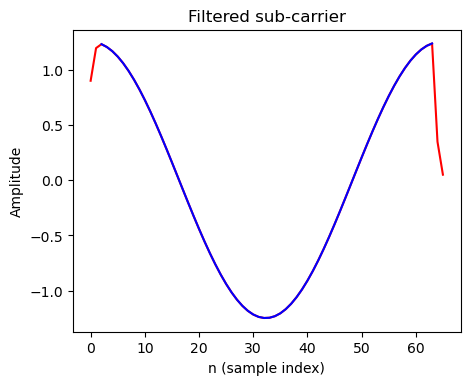

In [53]:
fig=plt.figure(figsize=(5,4), dpi=100)
plt.plot(sc_filt,'r')
xvals = np.arange(66)
xvals = xvals[2:64]
plt.plot(xvals,sc_filt[2:64],'b')

plt.title('Filtered sub-carrier')
plt.xlabel('n (sample index)')
plt.ylabel('Amplitude')

In the above plot, the transient and decay stages are plotted in red. Conversely, the steady-stage is plotted in blue. 

It can be observed that the sub-carrier period of $N$ samples includes the transient and the steady-state periods. This can be confirmed by adding the transient and steady-state durations i.e. $L-1$ + $N-L+1$ = $N$. 

This is problematic because it means that the sub-carrier is no longer sinusoidal across $N$ samples or $T$ seconds. The transient destroys the sinuosoidal shape of the sub-carrier within the $N$ sample window. This also occurs for all other sub-carriers in the OFDM symbol. This leads to a violation of the sub-carrier orthogonality. It is also necessary for the amplitude and phase of each sub-carrier to remain constant over a duration of $T$ seconds or $N$ samples to maintain orthogonality. However, this is no longer the case - its actually constant during the steady-state period i.e. $N-L+1 = 64-3+1 = 62$ samples. 

The decay stage is also an issue because it causes interference with the same sub-carrier in the subsequent OFDM symbol. This is due to the fact that the second symbol is sent immediately after the first symbol and so on i.e there is no guard interval between symbols (yet). This phenomenon is known as ISI and causes a severe performance degradation.

Clearly, this discussion has demonstrated that multipath channels have a detrimental effect on OFDM signals. This would appear to mitigate any potential advantages of using OFDM. However, these issues can be resolved by the addition of a special guard interval called the Cyclic Prefix (CP). 

## 4. The Cyclic Prefix <a class="anchor" id="cp"></a>

The CP is formed by extracting a portion of the end of the OFDM symbol and appending it to the front. The CP is made to be longer than the expected delay spread. This is possible because the OFDM symbol period is much greater than the delay spread.  

In order to demonstrate the addition of a CP, we will again consider the in-phase component of a single sub-carrier.

Refrerring to [Figure 3.1](#fig-3.1), we can see that the first multipath component arrives immediately and the last multipath component arrives 2 samples later, meaning that $d_{s}$ equals 2 sample periods. We will therefore choose a CP length of 4 (slightly longer than strictly necessary). In the following code cell, we will append the CP samples and plot the resulting waveform:

Text(0, 0.5, 'Amplitude')

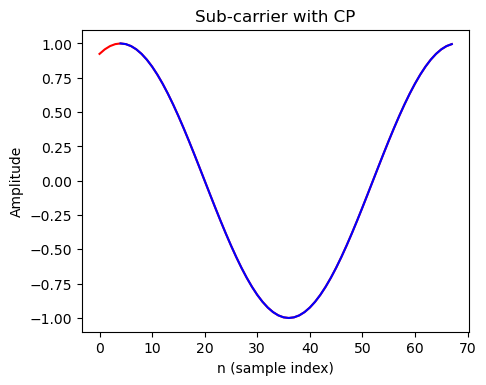

In [54]:
# Extract CP samples 
cp = sc_real[60:64]

# Append to front of sub-carrier 
sc_cp = np.concatenate((cp, sc_real))

# Plot resulting waveform 
fig=plt.figure(figsize=(5,4), dpi=100)
plt.plot(sc_cp,'r')
xvals = np.arange(68)
xvals = xvals[4:68]
plt.plot(xvals,sc_cp[4:68],'b')

plt.title('Sub-carrier with CP')
plt.xlabel('n (sample index)')
plt.ylabel('Amplitude')

In the above plot, the CP samples are highlighted in red. The first thing we notice is that there is no discontinuity between the CP and the sub-carrier. This is due to the fact that there is exactly one period of the sub-carrier in the OFDM symbol period i.e. $N$ = 64 samples in this example. There is also no discontinuity for the other sub-carriers because they all have an integer number of periods within the OFDM symbol period. This is beneficial since it prevents generation of spurious high frequency components, due to discontinuities between the symbol and the guard interval. However, ultimately, there is still discontinuities between the OFDM symbols themselves. These discontinuities are addressed using windowing techniques.   

The full OFDM symbol (including CP) can be formed by adding CPs to each individual sub-carrier and summing the resulting waveforms together. This is equivalent to first using the IFFT to generate the sum of modulated orthogonal sub-carriers (OFDM symbol) and then adding a CP at the beginning of the symbol. As we've learned, the latter approach is used in practice. 

Having described the mechanics of adding the CP, we can now demonstrate how it addresses the problems caused by the multipath channel. In order to do this, we will pass the sub-carrier with CP through the channel and plot the output signal: 

In [55]:
# Pass sub-carrier with CP through channel filter 
sc_filt_cp = np.convolve(sc_cp, h)

With the cylic extension of 4 samples, the input signal is now $N+4 = 68$ samples long. Using [Figure 3.2](#fig-3.2), we can calculate that the output signal will have a length of $N+L-1 = 68+3-1 = 70$ samples. This is confirmed below:

In [56]:
len(sc_filt_cp)

70

We can now plot the received waveform:

Text(0, 0.5, 'Amplitude')

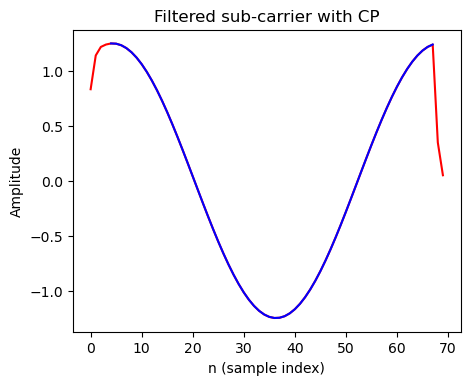

In [57]:
# Plot received waveform 
fig=plt.figure(figsize=(5,4), dpi=100)
plt.plot(sc_filt_cp,'r')
xvals = np.arange(70)
xvals = xvals[4:68]
plt.plot(xvals,sc_filt_cp[4:68],'b')

plt.title('Filtered sub-carrier with CP')
plt.xlabel('n (sample index)')
plt.ylabel('Amplitude')

In the above plot, the CP samples and the decay transient are plotted in red. Again, the steady-state portion is plotted in blue.

Let's focus on the CP samples. Recall that the transient of the multipath channel is 2 samples long and that the CP is 4 samples long. This means that the CP is "on" or being transmitted during the transient of the multipath channel and therefore is able to absorb it. Note the CP is slightly longer than necessary to absorb the transient.

Now, let's look at the steady-state portion of the signal. Immediately, we can now that it is $N$ samples long and that it has the desired sinusoidal shape. Therefore, the CP preserves the sinusoidal shape of the sub-carriers and thus their orthogonality is maintained. Furthermore, the amplitude and phase of each sub-carrier is constant over the window of $N$ samples or $T$ seconds, as required. 

Finally, we still have the decay transient. Although it is not shown explicitly, the decay transient occurs during the CP of the next symbol. Therefore, the CP of the next symbol absorbs ISI from the current symbol. As long as the CP is longer than $d_{s}$, the CP will completely eliminate ISI. In general, the CP will absorb a combination of the transient stage of the current symbol and the decay stage of the previous symbol. 

### 4.1 One Tap Equaliser <a class="anchor" id="onetap"></a>

In addition to addressing issues related to multipath channels, the CP has one other important role to play in OFDM systems. Namely, it leads to the so-called one tap equaliser. 

In order to understand this, we need to recall the convolution theorem. The convolution theorem states that linear convolution in time is equivalent to multiplication in frequency, followed by the inverse transformation. However, this is only true for continuous time signals.  

In discrete time, the convolution theorem is slightly different. In this case, multiplication in frequency followed by inverse transformation is equivalent to periodic or circular convolution in the time domain. What is circular convolution?

To take a familiar example, circular convolution arises if we pass an $N$ periodic discrete-time signal through a standard FIR filter. Assuming an $N$ periodic input signal,$x[n]$, and filter weights,$h[m]$, the output signal ,$y[n]$, is given by:

$$ y[n] = \sum_{m=0}^{L-1} h[m] x_{N}[n-m], $$ 

where $L$ is again the number of coefficients, $m$ is the coefficient index and $x_{N}$ denotes that $x[n]$ is $N$ periodic. Since $x[n]$ is $N$ periodic, it follows that $y[n]$ is also $N$ periodic, and hence the convolution is circular.    

So why is multiplication in discrete frequency equivalent to circular convolution in discrete time? We can answer this by considering how we might perform convolution using $H[k]$ and $X[k]$ i.e. the $N$ point DFTs of $h[m]$ and $x[n]$ respectively. This would be achieved by taking the $N$ point IDFT of the product of $H[k]$ and $X[k]$,    

$$ IDFT\{H[k] X[k]\}.$$

It is possible to perform a full mathematical derivation and show that the above operation produces a single period of $y[n]$ i.e. the circular convolution of $h[m]$ and $x[n]$. However, we can see this somewhat intuitively by recalling that the time domain sequence produced by an IDFT is always $N$ periodic, where $N$ is the IDFT size. This is because the complex exponential basis functions are $N$ periodic. A full derivation of this can be found in the following YouTube video:

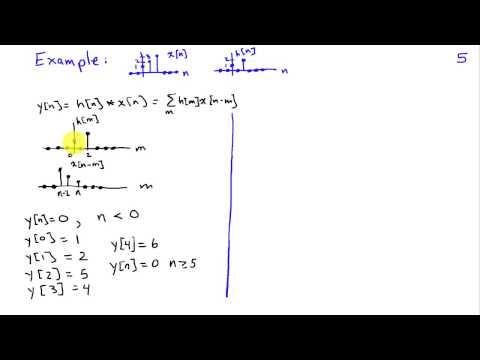

In [58]:
from IPython.display import YouTubeVideo

YouTubeVideo('eOvMUtMoQG8', width=500, height=300)

Now, why is this relevant to OFDM? Well, we would like to exploit the fact that convolution in time is equivalent to multiplication in frequency for equalisation after the FFT in the receiver. If the OFDM system is designed correctly, then the channel response is reduced to a single complex multiplication per sub-carrier after the FFT. The channel can then be equalised via a complex division per sub-carrier or one tap equaliser.

However, the problem remains that the channel will perform a linear convolution. So how can we make the convolution circular so that the above relation is true? Examining the equation for circular convolution, we can see that a way to do this is to periodically extend the input signal. Obvioulsy, we can't extend it infinitely so the question is how much extension is actually necessary? 

The question can be reformulated more precisley by asking how much we need to periodically extend $x[n]$ to produce one period of $y[n]$. Note, we only need to compute one period of $y[n]$, since it is periodic. Recall that an FIR filter has a memory consisting of the current sample and $L-1$ past samples. This means we only have to consider at most $L-1$ samples before the beginning of $x[n].$ Therefore, it is only necessary to periodically extend $x[n]$ by a minimum of $L-1$ samples to the left, since anything beyond that is irrelevant to the calculation.    

For a real world channel, it's neccesary to periodically extend the signal by at least $d_{s}$ seconds to the left. The number of samples required depends on the sampling rate. As we know, the OFDM system is designed such that $T$ or $N$ is a much longer period of time than $d_{s}$. Therefore, each OFDM symbol only has to be periodically extended by a fraction of a period to the left. As you'll recognise, this is exactly what we have done with the CP. 

To confirm that this works, let's revist our filtered sub-carrier with CP from before and just extract the steady-state portion of the waveform i.e. discard the CP and decay samples at the beginning and end respectively:

In [59]:
# Extract steady-state portion of output signal
sc_ss = sc_filt_cp[4:68]  

The steady-state waveform should correspond to one period of the circular convolution of the filter (channel) impulse response and the sub-carrier. We can prove this by first calculating the circular convolution using the FFT method:   

In [60]:
# Calculate H[k] and X[k]
Hk = np.fft.fft(h,N)
Xk = np.fft.fft(sc_real,N)

# IDFT of  H[k] x X[k] 
y = np.fft.ifft(Hk * Xk)

Let's now measure the MSE between the two signals to confirm that the steady-state waveform is equivalent to the circular convolution of the sub-carrier and the impulse response:

In [61]:
mse = np.mean(abs(y-sc_ss)**2)

In [62]:
mse

2.0792144077344621e-32

Therefore, by adding a CP with an appropriate length to each OFDM symbol, we obtain one repetition of the circular convolution of each OFDM symbol and the channel impulse response. Subsequently, after the FFT is performed in the receiver, the underlying data symbols in each OFDM symbol can be equalised as:

$$ \hat{X}[k] = \frac{Y[k]}{\hat{H}[k]}, $$

where $\hat{X}[k]$ are the estimated data symbols, $Y[k]$ are the received symbols and $\hat{H}[k]$ is the estimated channel frequency response. This calculation is performed for each individual sub-carrier $k$. This one-tap equaliser is very computationally efficient and is one of the main advantages of OFDM.    

# 5. Updated OFDM Transmitter <a class="anchor" id="tx_update"></a>

Based on the learning of the previous sections, we can draw an updated diagram of an OFDM transmitter:

<a class="anchor" id="fig-5.1"></a>
<figure>
<img src="images/ofdm_tx_2 copy.svg" style="width: 1000px;"/> 
    <figcaption><b>Figure 5.1: Updated OFDM Transmitter </b></figcaption>
</figure>   

The first stage in the process is mapping the data bits to symbols i.e. BPSK, QPSK, 16-QAM etc. The symbols are then organised into groups of $N$ (in practice, less than this due to the use of pilots and null sub-carriers) and a series of $N$ point IFFTs are performed to generate the OFDM symbols. Finally, a CP is added to the beginning of each symbol to provide reslience to multipath channels and facilitate the one-tap equliser. Although not indicated in [Figure 5.1](#fig-5.1), the data bits are normally scrambled and then forward error correction and interleaving are performed before the symbol mapping. After the CP is addition, the signal is up converted to Radio Frequency (RF) and transmitted across the channel.

# 6. Conclusion <a class="anchor" id="conclusion"></a>

In conclusion, this notebook has introdcued the fundamental theory of OFDM. Due to a number of advantages, OFDM has been chosen as the basis of several well known communications standards such as the IEEE 802.11 family (Wi-Fi), 4G LTE and most recently 5G NR. 

In this notebook, we provided an overview of the OFDM transmission processs and showed that modulation and demodulation can be  performed efficiently using an IFFT/FFT pair. We then briefly reviewed multipath channels and showed that they cause a loss of sub-carrier orthogonality and ISI. Subsequently, it was shown that these problems can be resolved by adding a special guard interval between symbols known as the CP. The CP is formed by copying a fraction of the end of the symbol and appending it to the front. The use of a CP prevents any discontinuity between the guard interval and the OFDM symbol. Finally, we showed that the addition of a CP prodcues a circular convolution with the channel and leads to the computationally efficient one tap equaliser. 

In the next notebook, we will demonstrate an OFDM transceiver including equalisation in the receiver. 